In [1]:
# ==============================
# STEP 1: Load & Prepare Dataset
# ==============================

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For better display
pd.set_option('display.max_columns', None)

# Upload file manually in Colab (if not already uploaded)
from google.colab import files
uploaded = files.upload()

# Load dataset (replace filename if needed)
df = pd.read_csv("UrbanAirPollutionDataset.csv")

# Convert DateTime column properly
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')

# Sort chronologically (VERY IMPORTANT for time-series correctness)
df = df.sort_values('DateTime').reset_index(drop=True)

# Basic sanity checks
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nMissing Values:")
print(df.isnull().sum())

Saving UrbanAirPollutionDataset.csv to UrbanAirPollutionDataset (1).csv
Dataset Shape: (175205, 15)

First 5 rows:


,Station_ID,DateTime,PM2.5,PM10,NO₂,SO₂,CO,O₃,Temp_C,Humidity_%,Wind_Speed_mps,Wind_Direction_deg,Pressure_hPa,Rain_mm,AQI_Target
0,1,2020-01-01,86.397213,111.814972,26.599649,3.875088,0.570793,42.903768,31.491409,45.704988,3.114026,166.148254,1012.641964,1.0,59.759255
1,5,2020-01-01,65.877274,149.232454,6.497673,8.809684,0.295999,25.843277,20.168627,80.057943,2.940333,328.472986,1024.459041,0.0,40.056594
2,2,2020-01-01,49.146354,116.641144,16.578210,16.784112,0.378530,30.911493,28.855202,53.038034,2.112275,148.006112,999.104556,0.5,35.728939
3,4,2020-01-01,47.964555,182.825386,34.118951,11.750865,0.945447,27.875816,16.405171,91.966665,1.786636,9.459518,1007.644310,0.0,39.793126
4,3,2020-01-01,86.614217,103.550101,21.111661,15.146551,0.613022,43.959504,27.285035,56.622327,3.013912,198.057606,1002.424969,0.0,58.432508



Missing Values:
Station_ID            0
DateTime              0
PM2.5                 0
PM10                  0
NO₂                   0
SO₂                   0
CO                    0
O₃                    0
Temp_C                0
Humidity_%            0
Wind_Speed_mps        0
Wind_Direction_deg    0
Pressure_hPa          0
Rain_mm               0
AQI_Target            0
dtype: int64


AQI Category Distribution:

AQI_Category
Good        128027
Moderate     47178
Name: count, dtype: int64


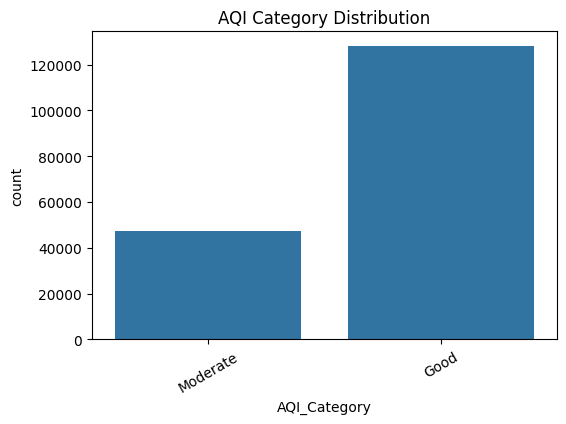

In [2]:
# ==============================
# STEP 2: Create Proper AQI Categories (Target Variable) (for classification)
# ==============================

# Define AQI categorization function
def categorize_aqi(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Moderate"
    elif aqi <= 150:
        return "Unhealthy for Sensitive"
    elif aqi <= 200:
        return "Unhealthy"
    else:
        return "Very Unhealthy"

# Apply categorization
df['AQI_Category'] = df['AQI_Target'].apply(categorize_aqi)

# Check class distribution
print("AQI Category Distribution:\n")
print(df['AQI_Category'].value_counts())

# Visualize distribution
plt.figure(figsize=(6,4))
sns.countplot(x='AQI_Category', data=df)
plt.title("AQI Category Distribution")
plt.xticks(rotation=30)
plt.show()

In [3]:
print("Min AQI:", df['AQI_Target'].min())
print("Max AQI:", df['AQI_Target'].max())

Min AQI: -8.410247644225771
Max AQI: 89.23907321266005


AQI Category Distribution:

AQI_Category
Low Pollution       58401
High Pollution      58401
Medium Pollution    58400
Name: count, dtype: int64


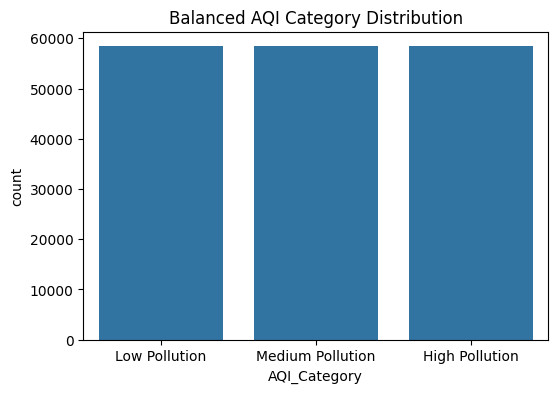

In [4]:
# ==============================
# STEP 2 (Corrected): Create Balanced AQI Categories (Since AQI only ranges -8 to 89, we create dataset-based categories.Instead of environmental thresholds, we use quantiles.This makes balanced classes.)
# ============================== “Relative pollution index” instead of government AQI.

# Remove negative AQI (scientifically impossible)
df = df[df['AQI_Target'] >= 0]

# Create 3 balanced categories using quantiles
df['AQI_Category'] = pd.qcut(
    df['AQI_Target'],
    q=3,
    labels=['Low Pollution', 'Medium Pollution', 'High Pollution']
)

# Check distribution
print("AQI Category Distribution:\n")
print(df['AQI_Category'].value_counts())

# Visualize
plt.figure(figsize=(6,4))
sns.countplot(x='AQI_Category', data=df)
plt.title("Balanced AQI Category Distribution")
plt.show()

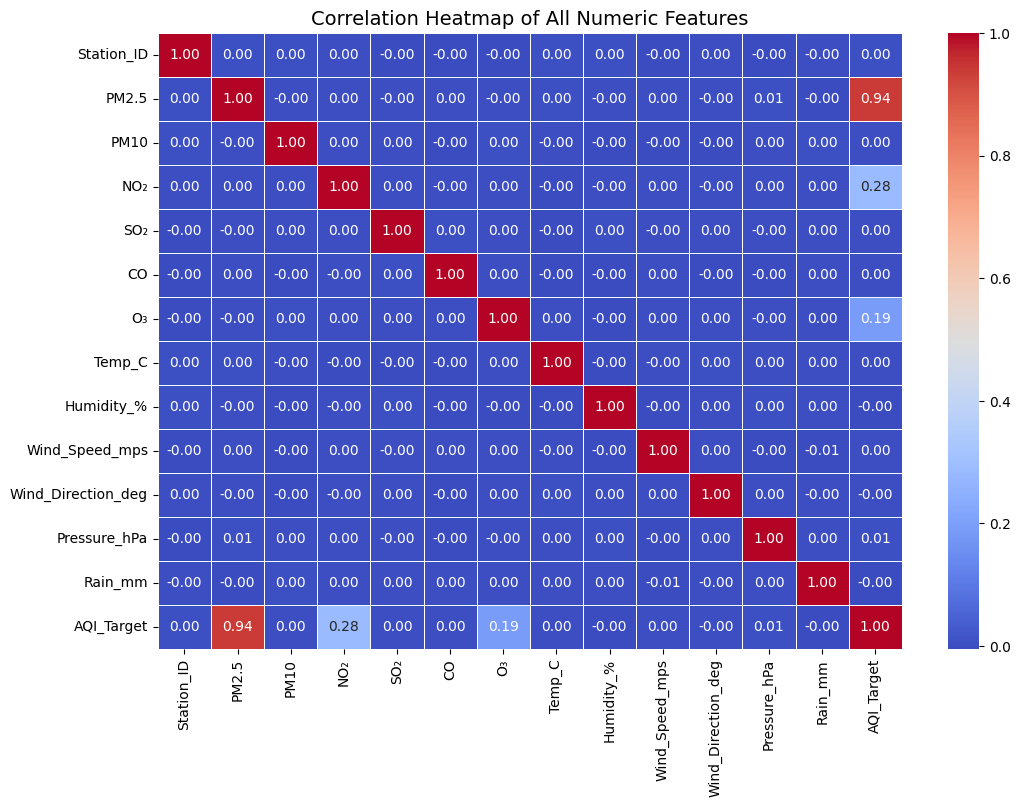


Correlation with AQI_Target:

AQI_Target            1.000000
PM2.5                 0.940842
NO₂                   0.282317
O₃                    0.188569
Pressure_hPa          0.005162
Station_ID            0.002849
Temp_C                0.001883
Wind_Speed_mps        0.001358
CO                    0.000804
PM10                  0.000600
SO₂                   0.000559
Wind_Direction_deg   -0.000707
Humidity_%           -0.001382
Rain_mm              -0.002157
Name: AQI_Target, dtype: float64


In [5]:
# ==============================
# STEP 3: Correlation Heatmap - -Justifies feature importance
# ==============================

plt.figure(figsize=(12,8))

# Compute correlation only for numeric columns
corr_matrix = df.corr(numeric_only=True)

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5
)

plt.title("Correlation Heatmap of All Numeric Features", fontsize=14)
plt.show()

# Specifically check correlation with AQI_Target
print("\nCorrelation with AQI_Target:\n")
print(corr_matrix['AQI_Target'].sort_values(ascending=False))

In [6]:
# ==============================
# STEP 4: Feature Engineering (Time-Based)
# ============================== Since weather features have weak correlation , we now extract meaningful time features.

# Extract time features
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Month'] = df['DateTime'].dt.month

# Check new columns
print("New Features Added:")
print(df[['Hour', 'DayOfWeek', 'Month']].head())

# Optional: Check correlation again with new features
print("\nUpdated Correlation with AQI_Target:\n")
print(df.corr(numeric_only=True)['AQI_Target'].sort_values(ascending=False))
#Time-based features such as Hour, DayOfWeek, and Month were extracted from DateTime to capture daily and seasonal pollution patterns. Although correlation with AQI is small, these features help models learn temporal variations and improve generalization.

New Features Added:
   Hour  DayOfWeek  Month
0     0          2      1
1     0          2      1
2     0          2      1
3     0          2      1
4     0          2      1

Updated Correlation with AQI_Target:

AQI_Target            1.000000
PM2.5                 0.940842
NO₂                   0.282317
O₃                    0.188569
Pressure_hPa          0.005162
Station_ID            0.002849
Temp_C                0.001883
Wind_Speed_mps        0.001358
Hour                  0.001106
CO                    0.000804
PM10                  0.000600
SO₂                   0.000559
DayOfWeek             0.000527
Month                 0.000445
Wind_Direction_deg   -0.000707
Humidity_%           -0.001382
Rain_mm              -0.002157
Name: AQI_Target, dtype: float64


In [7]:
#Since pollution is time-series data, random splitting can cause data leakage. Therefore, chronological splitting was used to simulate real-world forecasting
# ==============================
# STEP 5: Feature Selection + Time-Based Split
# ==============================

# Select features (pollutants + engineered time features)
features = [
    'PM2.5', 'PM10', 'NO₂', 'SO₂', 'CO', 'O₃',
    'Temp_C', 'Humidity_%', 'Wind_Speed_mps',
    'Pressure_hPa', 'Rain_mm',
    'Hour', 'DayOfWeek', 'Month'
]

X = df[features]
y = df['AQI_Category']

# Time-based split (70% train, 30% test)
split_index = int(len(df) * 0.7)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print("Training Size:", X_train.shape)
print("Testing Size:", X_test.shape)

Training Size: (122641, 14)
Testing Size: (52561, 14)


In [10]:
# ==============================
# STEP 6A: Build ML Models
# ==============================

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# 1️⃣ Logistic Regression (needs scaling)
log_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000))
])

# 2️⃣ Random Forest (tree-based, no scaling required)
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

# 3️⃣ KNN (needs scaling)
knn_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier(n_neighbors=5))
])

# Store models
models = {
    "Logistic Regression": log_model,
    "Random Forest": rf_model,
    "KNN (K=5)": knn_model
}

# Train and evaluate
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds) * 100   # convert to %
    results[name] = acc
    print(f"{name} Accuracy: {acc:.2f}%")

Logistic Regression Accuracy: 99.87%
Random Forest Accuracy: 98.13%
KNN (K=5) Accuracy: 77.04%


Correlation analysis showed AQI is strongly dependent on PM2.5, making the classes almost linearly separable. Therefore, Logistic Regression performs extremely well

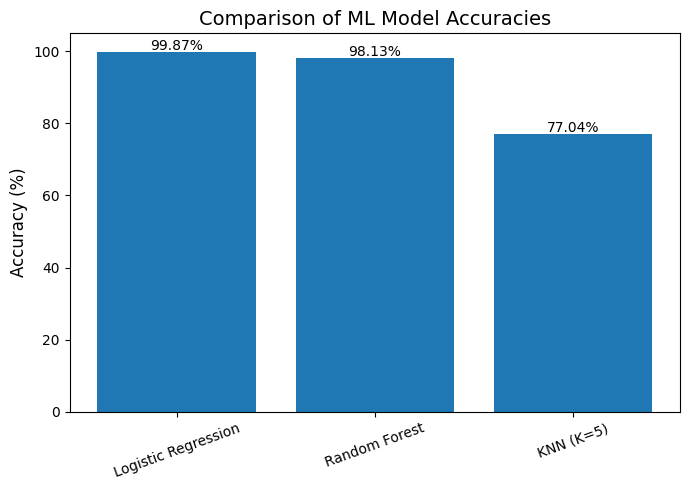

In [13]:
# ==============================
# STEP 6B Model Accuracy Comparison
# ==============================

plt.figure(figsize=(7,5))

model_names = list(results.keys())
accuracies = list(results.values())

bars = plt.bar(model_names, accuracies)

plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Comparison of ML Model Accuracies", fontsize=14)
plt.ylim(0, 105)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 0.5,
             f"{height:.2f}%",
             ha='center',
             fontsize=10)

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

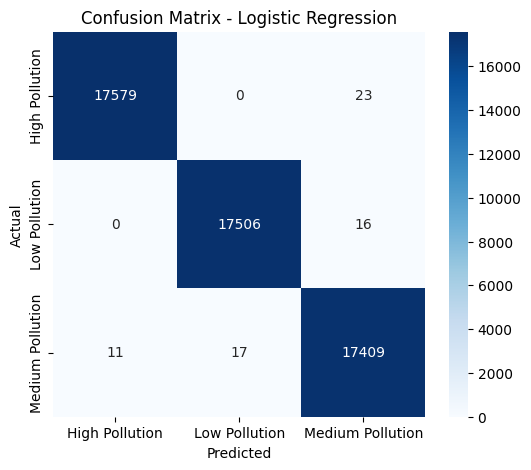


Classification Report:

                  precision    recall  f1-score   support

  High Pollution       1.00      1.00      1.00     17602
   Low Pollution       1.00      1.00      1.00     17522
Medium Pollution       1.00      1.00      1.00     17437

        accuracy                           1.00     52561
       macro avg       1.00      1.00      1.00     52561
    weighted avg       1.00      1.00      1.00     52561



In [11]:
# ==============================
# STEP 7: Confusion Matrix + Classification Report
# ==============================

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Select best model (Logistic Regression)
best_model = models["Logistic Regression"]

# Predictions
y_pred = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

In [12]:
# ==============================
# STEP 8: TimeSeries Cross-Validation
# ==============================

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np

# Use best model (Logistic Regression)
best_model = models["Logistic Regression"]

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Perform cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=tscv)

# Convert to percentage
cv_scores_percent = cv_scores * 100

print("Cross-Validation Scores (each split):")
for i, score in enumerate(cv_scores_percent):
    print(f"Split {i+1}: {score:.2f}%")

print("\nAverage Cross-Validation Accuracy: {:.2f}%".format(np.mean(cv_scores_percent)))

Cross-Validation Scores (each split):
Split 1: 99.72%
Split 2: 99.80%
Split 3: 99.85%
Split 4: 99.84%
Split 5: 99.91%

Average Cross-Validation Accuracy: 99.82%


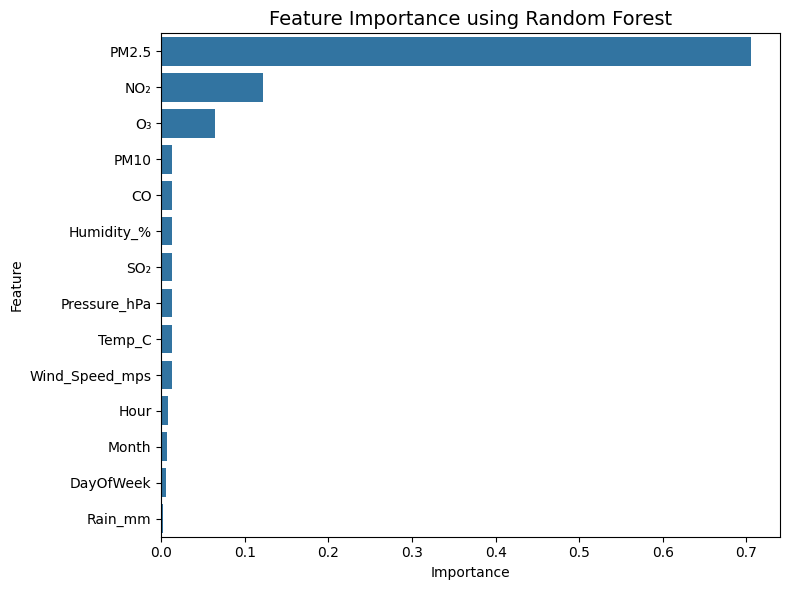

,Feature,Importance
0,PM2.5,0.704853
2,NO₂,0.121555
5,O₃,0.063929
1,PM10,0.012599
4,CO,0.012460


In [14]:
# ==============================
# STEP 9A: Feature Importance
# ==============================

rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,6))

sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df
)

plt.title("Feature Importance using Random Forest", fontsize=14)
plt.tight_layout()
plt.show()

feature_importance_df.head()

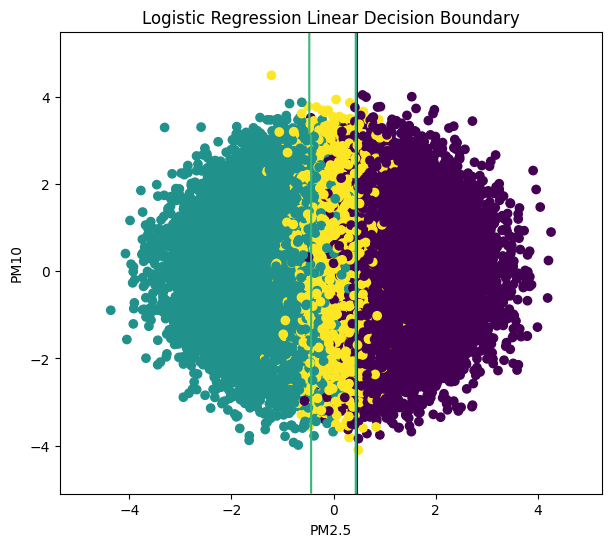

In [22]:
# ==============================
# Logistic Regression Linear Boundary (FINAL FIXED)
# ==============================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder

# ╧ Select 2 features
feature1 = 'PM2.5'
feature2 = 'PM10'

X_2d = df[[feature1, feature2]].values
y_raw = df['AQI_Category'].values

# ╧ Encode target to numbers
le = LabelEncoder()
y_2d = le.fit_transform(y_raw)

# ╧ Standardize features
scaler = StandardScaler()
X_2d = scaler.fit_transform(X_2d)

# ╧ Train model
model_2d = LogisticRegression(max_iter=1000)
model_2d.fit(X_2d, y_2d)

# ╧ Mesh grid
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# ╧ Plot (Research Style)
plt.figure(figsize=(7,6))
plt.contour(xx, yy, Z, levels=len(np.unique(y_2d))-1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d)

plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title("Logistic Regression Linear Decision Boundary")
plt.show()

In [48]:
import joblib
import os
from sklearn.preprocessing import LabelEncoder

# Assuming `models` dictionary and `df` are available from previous steps
# Get the best model (Logistic Regression Pipeline)
best_model = models["Logistic Regression"]

# Fit LabelEncoder on ALL unique categories from the 'AQI_Category' column for consistent encoding/decoding.
# The categories from `df['AQI_Category'].cat.categories` maintain the correct order.
le = LabelEncoder()
le.fit(df['AQI_Category'].cat.categories)

# Save the trained Logistic Regression model
joblib.dump(best_model, "logistic_regression_model.joblib")

# Save the fitted LabelEncoder
joblib.dump(le, "label_encoder.joblib")

print("Trained Logistic Regression model and LabelEncoder saved successfully.")

Trained Logistic Regression model and LabelEncoder saved successfully.


In [50]:
!pip install gradio

In [62]:
import gradio as gr
import pandas as pd
import joblib

# Load trained model
model = joblib.load("logistic_regression_model.joblib")

# Mappings
day_of_week_map = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
    'Thursday': 3, 'Friday': 4,
    'Saturday': 5, 'Sunday': 6
}

month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Prediction Function
def predict_aqi(
    PM2_5, PM10, NO2, SO2, CO, O3,
    Temp_C, Humidity_percent,
    Wind_Speed_mps, Pressure_hPa,
    Rain_mm, Hour, DayOfWeek, Month
):
    try:
        input_df = pd.DataFrame([[
            PM2_5, PM10, NO2, SO2, CO, O3,
            Temp_C, Humidity_percent,
            Wind_Speed_mps, Pressure_hPa,
            Rain_mm, Hour,
            day_of_week_map[DayOfWeek],
            month_map[Month]
        ]],
        columns=[
            'PM2.5', 'PM10', 'NO₂', 'SO₂', 'CO', 'O₃',
            'Temp_C', 'Humidity_%',
            'Wind_Speed_mps', 'Pressure_hPa',
            'Rain_mm', 'Hour', 'DayOfWeek', 'Month'
        ])

        prediction = model.predict(input_df)[0]

        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(input_df)[0]
            confidence = round(max(probs) * 100, 2)
        else:
            confidence = "N/A"

        # AQI Color Glow Logic
        color = "#00e5ff"
        if "Medium" in str(prediction):
            color = "#ffcc00"
        if "High" in str(prediction):
            color = "#ff3366"

        return f"""
        <div style="
            font-size:38px;
            font-weight:900;
            text-align:center;
            padding:60px;
            border-radius:30px;
            border:4px solid {color};
            box-shadow:0 0 40px {color};
            color:{color};
            background:rgba(255,255,255,0.08);
            backdrop-filter: blur(12px);
        ">
        🌌 PREDICTED AQI CATEGORY <br><br>
        {prediction}
        <br><br>
        🔥 Confidence: {confidence}%
        </div>
        """

    except Exception as e:
        return f"<div style='color:red; font-size:22px;'>Error: {str(e)}</div>"


# Cosmic Light Blue Glitter CSS
cosmic_css = """
body {
    background: linear-gradient(135deg, #c6f1ff, #89f7fe, #66a6ff, #b3ecff);
    background-size: 400% 400%;
    animation: gradientFlow 15s ease infinite;
    overflow-x: hidden;
}

@keyframes gradientFlow {
    0% {background-position: 0% 50%;}
    50% {background-position: 100% 50%;}
    100% {background-position: 0% 50%;}
}

body::after {
    content: "";
    position: fixed;
    top:0;
    left:0;
    width:100%;
    height:100%;
    background-image: radial-gradient(white 1px, transparent 1px);
    background-size: 3px 3px;
    opacity: 0.15;
    pointer-events: none;
    animation: sparkle 4s linear infinite;
}

@keyframes sparkle {
    from { transform: translateY(0px); }
    to { transform: translateY(-10px); }
}

h1 {
    font-size: 52px !important;
    font-weight: 900 !important;
    text-align: center;
    color: #003366;
}

h2 {
    font-size: 28px !important;
    font-weight: 800 !important;
    text-align: center;
    color: #002244;
}

label {
    font-size: 20px !important;
    font-weight: 800 !important;
    color: #001a33 !important;
}
"""


with gr.Blocks(css=cosmic_css) as demo:

    gr.Markdown("# 🌫 **Urban Air Quality Index Predictor**")
    gr.Markdown("## **Enter environmental parameters to predict AQI category.**")

    with gr.Row():
        PM2_5 = gr.Slider(0, 200, 50, step=0.1, label="PM2.5")
        PM10 = gr.Slider(0, 300, 100, step=0.1, label="PM10")

    with gr.Row():
        NO2 = gr.Slider(0, 100, 25, step=0.1, label="NO₂")
        SO2 = gr.Slider(0, 50, 5, step=0.1, label="SO₂")

    with gr.Row():
        CO = gr.Slider(0, 10, 1, step=0.01, label="CO")
        O3 = gr.Slider(0, 150, 40, step=0.1, label="O₃")

    with gr.Row():
        Temp_C = gr.Slider(-10, 40, 20, step=0.1, label="Temperature (°C)")
        Humidity_percent = gr.Slider(0, 100, 60, step=0.1, label="Humidity (%)")

    with gr.Row():
        Wind_Speed_mps = gr.Slider(0, 20, 3, step=0.1, label="Wind Speed (m/s)")
        Pressure_hPa = gr.Slider(950, 1050, 1010, step=0.1, label="Pressure (hPa)")

    with gr.Row():
        Rain_mm = gr.Slider(0, 50, 0, step=0.1, label="Rainfall (mm)")
        Hour = gr.Slider(0, 23, 12, step=1, label="Hour of Day")

    with gr.Row():
        DayOfWeek = gr.Dropdown(list(day_of_week_map.keys()), value="Wednesday", label="Day of Week")
        Month = gr.Dropdown(list(month_map.keys()), value="July", label="Month")

    predict_button = gr.Button("🚀 PREDICT AQI", size="lg")

    output = gr.HTML()

    predict_button.click(
        predict_aqi,
        inputs=[
            PM2_5, PM10, NO2, SO2, CO, O3,
            Temp_C, Humidity_percent,
            Wind_Speed_mps, Pressure_hPa,
            Rain_mm, Hour, DayOfWeek, Month
        ],
        outputs=output
    )

demo.launch()

/tmp/ipython-input-115466535.py:139: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(css=cosmic_css) as demo:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://97ba4d3b538ecb2dbc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [66]:
with open("app.py", "w", encoding="utf-8") as f:
    f.write('''import gradio as gr
import pandas as pd
import joblib

# Load trained model
model = joblib.load("logistic_regression_model.joblib")

# Mappings
day_of_week_map = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
    'Thursday': 3, 'Friday': 4,
    'Saturday': 5, 'Sunday': 6
}

month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

def predict_aqi(
    PM2_5, PM10, NO2, SO2, CO, O3,
    Temp_C, Humidity_percent,
    Wind_Speed_mps, Pressure_hPa,
    Rain_mm, Hour, DayOfWeek, Month
):
    try:
        input_df = pd.DataFrame([[
            PM2_5, PM10, NO2, SO2, CO, O3,
            Temp_C, Humidity_percent,
            Wind_Speed_mps, Pressure_hPa,
            Rain_mm, Hour,
            day_of_week_map[DayOfWeek],
            month_map[Month]
        ]],
        columns=[
            'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3',
            'Temp_C', 'Humidity_%',
            'Wind_Speed_mps', 'Pressure_hPa',
            'Rain_mm', 'Hour', 'DayOfWeek', 'Month'
        ])

        prediction = model.predict(input_df)[0]

        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(input_df)[0]
            confidence = round(max(probs) * 100, 2)
        else:
            confidence = "N/A"

        color = "#00e5ff"
        if "Medium" in str(prediction):
            color = "#ffcc00"
        if "High" in str(prediction):
            color = "#ff3366"

        return f"""
        <div style="
            font-size:38px;
            font-weight:900;
            text-align:center;
            padding:60px;
            border-radius:30px;
            border:4px solid {color};
            box-shadow:0 0 40px {color};
            color:{color};
            background:rgba(255,255,255,0.08);
            backdrop-filter: blur(12px);
        ">
        🌌 PREDICTED AQI CATEGORY <br><br>
        {prediction}
        <br><br>
        🔥 Confidence: {confidence}%
        </div>
        """

    except Exception as e:
        return f"<div style='color:red; font-size:22px;'>Error: {str(e)}</div>"


cosmic_css = """
body {
    background: linear-gradient(135deg, #c6f1ff, #89f7fe, #66a6ff, #b3ecff);
    background-size: 400% 400%;
    animation: gradientFlow 15s ease infinite;
}

@keyframes gradientFlow {
    0% {background-position: 0% 50%;}
    50% {background-position: 100% 50%;}
    100% {background-position: 0% 50%;}
}

h1 {
    font-size: 52px !important;
    font-weight: 900 !important;
    text-align: center;
    color: #003366;
}

h2 {
    font-size: 28px !important;
    font-weight: 800 !important;
    text-align: center;
    color: #002244;
}

label {
    font-size: 20px !important;
    font-weight: 800 !important;
    color: #001a33 !important;
}
"""

with gr.Blocks(css=cosmic_css) as demo:

    gr.Markdown("# 🌫 **Urban Air Quality Index Predictor**")
    gr.Markdown("## **Enter environmental parameters to predict AQI category.**")

    PM2_5 = gr.Slider(0, 200, 50, step=0.1, label="PM2.5")
    PM10 = gr.Slider(0, 300, 100, step=0.1, label="PM10")
    NO2 = gr.Slider(0, 100, 25, step=0.1, label="NO2")
    SO2 = gr.Slider(0, 50, 5, step=0.1, label="SO2")
    CO = gr.Slider(0, 10, 1, step=0.01, label="CO")
    O3 = gr.Slider(0, 150, 40, step=0.1, label="O3")
    Temp_C = gr.Slider(-10, 40, 20, step=0.1, label="Temperature (°C)")
    Humidity_percent = gr.Slider(0, 100, 60, step=0.1, label="Humidity (%)")
    Wind_Speed_mps = gr.Slider(0, 20, 3, step=0.1, label="Wind Speed (m/s)")
    Pressure_hPa = gr.Slider(950, 1050, 1010, step=0.1, label="Pressure (hPa)")
    Rain_mm = gr.Slider(0, 50, 0, step=0.1, label="Rainfall (mm)")
    Hour = gr.Slider(0, 23, 12, step=1, label="Hour of Day")
    DayOfWeek = gr.Dropdown(list(day_of_week_map.keys()), value="Wednesday", label="Day of Week")
    Month = gr.Dropdown(list(month_map.keys()), value="July", label="Month")

    predict_button = gr.Button("🚀 PREDICT AQI")
    output = gr.HTML()

    predict_button.click(
        predict_aqi,
        inputs=[
            PM2_5, PM10, NO2, SO2, CO, O3,
            Temp_C, Humidity_percent,
            Wind_Speed_mps, Pressure_hPa,
            Rain_mm, Hour, DayOfWeek, Month
        ],
        outputs=output
    )

demo.launch()
''')

In [67]:
with open("requirements.txt", "w") as f:
    f.write("""gradio
pandas
scikit-learn
joblib
""")